<a href="https://colab.research.google.com/github/janakg/era-s5/blob/main/S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

In [50]:
# import os

# # Define the repository and the target directory
# repo_url = 'https://github.com/janakg/era-s9.git'
# target_dir = '/content/era-s9'

# # Check if the directory already exists
# if not os.path.exists(target_dir):
#     # If it doesn't exist, clone the repo
#     !git clone {repo_url}
# else:
#     # If it exists, 'cd' into the directory and pull the latest changes
#     %cd {target_dir}
#     !git pull

# # Add the repository's directory to the system path
# import sys
# sys.path.append(target_dir)

# Import all utils functions
from utils import *

In [51]:
# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)


# For reproducibility. SEED Random functions
SEED = 1
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available? True


In [52]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transforms = A.Compose([
    A.Normalize(mean, std),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, 
                    min_height=16, min_width=16, fill_value=mean, mask_fill_value=None),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Normalize(mean, std),
    ToTensorV2()
])

class AlbumentationsCIFAR10Wrapper(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None):
        self.data = datasets.CIFAR10(root=root, train=train, download=download)
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = np.array(img)  # PIL Image to numpy array
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        return img, label

    def __len__(self):
        return len(self.data)

In [53]:
# Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomRotation(15),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        ])

# # Test Phase transformations
# test_transforms = transforms.Compose([
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#                                        ])


In [54]:
train_data = AlbumentationsCIFAR10Wrapper(root='./data', train=True, 
                                          download=True, transform=train_transforms)

test_data = AlbumentationsCIFAR10Wrapper(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [55]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


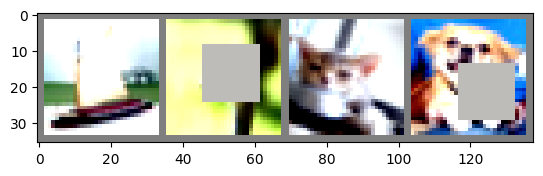

ship  bird  cat   dog  


In [56]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# # Call the util function to show a batch of images
# import matplotlib.pyplot as plt
# fig = plt.figure()
# show_batch_images(plt, train_loader, 12, 3, 4)

In [57]:
# model imported from a module
from model import Net

In [58]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]          18,432
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
             ReLU-14           [-1, 32,

In [59]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [60]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 100

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_succeeded, train_processed, train_loss = train(model, device, train_loader, optimizer, criterion)
  train_acc.append(100 * train_succeeded/train_processed)
  train_losses.append(train_loss / len(train_loader))

  test_succeeded, test_loss = test(model, device, test_loader, criterion)
  test_acc.append(100. * test_succeeded / len(test_loader.dataset))
  test_losses.append(test_loss)

  # scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss=1.5661 Batch_id=97 Accuracy=35.16: 100%|██████████| 98/98 [00:08<00:00, 10.89it/s]


Test set: Average loss: 1.4565, Accuracy: 4651/10000 (46.51%)

Epoch 2


Train: Loss=1.3422 Batch_id=97 Accuracy=47.64: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


Test set: Average loss: 1.3254, Accuracy: 5144/10000 (51.44%)

Epoch 3


Train: Loss=1.2351 Batch_id=97 Accuracy=52.68: 100%|██████████| 98/98 [00:09<00:00, 10.85it/s]


Test set: Average loss: 1.1910, Accuracy: 5679/10000 (56.79%)

Epoch 4


Train: Loss=1.1128 Batch_id=97 Accuracy=56.29: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]


Test set: Average loss: 1.0414, Accuracy: 6288/10000 (62.88%)

Epoch 5


Train: Loss=1.0534 Batch_id=97 Accuracy=59.57: 100%|██████████| 98/98 [00:09<00:00, 10.49it/s]


Test set: Average loss: 1.0699, Accuracy: 6257/10000 (62.57%)

Epoch 6


Train: Loss=0.9885 Batch_id=97 Accuracy=60.81: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


Test set: Average loss: 0.9757, Accuracy: 6610/10000 (66.10%)

Epoch 7


Train: Loss=0.9735 Batch_id=97 Accuracy=62.94: 100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Test set: Average loss: 0.9101, Accuracy: 6827/10000 (68.27%)

Epoch 8


Train: Loss=1.0269 Batch_id=97 Accuracy=64.33: 100%|██████████| 98/98 [00:08<00:00, 11.10it/s]


Test set: Average loss: 0.8996, Accuracy: 6837/10000 (68.37%)

Epoch 9


Train: Loss=0.9001 Batch_id=97 Accuracy=65.63: 100%|██████████| 98/98 [00:09<00:00, 10.79it/s]


Test set: Average loss: 0.8784, Accuracy: 6862/10000 (68.62%)

Epoch 10


Train: Loss=0.9004 Batch_id=97 Accuracy=66.53: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.8061, Accuracy: 7169/10000 (71.69%)

Epoch 11


Train: Loss=1.0140 Batch_id=97 Accuracy=67.71: 100%|██████████| 98/98 [00:09<00:00, 10.63it/s]


Test set: Average loss: 0.7793, Accuracy: 7250/10000 (72.50%)

Epoch 12


Train: Loss=0.8351 Batch_id=97 Accuracy=68.31: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.7901, Accuracy: 7219/10000 (72.19%)

Epoch 13


Train: Loss=0.7747 Batch_id=97 Accuracy=69.64: 100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Test set: Average loss: 0.7944, Accuracy: 7171/10000 (71.71%)

Epoch 14


Train: Loss=0.8382 Batch_id=97 Accuracy=70.41: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]


Test set: Average loss: 0.7163, Accuracy: 7519/10000 (75.19%)

Epoch 15


Train: Loss=0.7961 Batch_id=97 Accuracy=70.74: 100%|██████████| 98/98 [00:08<00:00, 10.98it/s]


Test set: Average loss: 0.7332, Accuracy: 7444/10000 (74.44%)

Epoch 16


Train: Loss=0.7688 Batch_id=97 Accuracy=71.02: 100%|██████████| 98/98 [00:08<00:00, 11.01it/s]


Test set: Average loss: 0.7138, Accuracy: 7474/10000 (74.74%)

Epoch 17


Train: Loss=0.7701 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:09<00:00, 10.57it/s]


Test set: Average loss: 0.6700, Accuracy: 7676/10000 (76.76%)

Epoch 18


Train: Loss=0.7658 Batch_id=97 Accuracy=72.55: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.6932, Accuracy: 7561/10000 (75.61%)

Epoch 19


Train: Loss=0.7193 Batch_id=97 Accuracy=73.16: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]


Test set: Average loss: 0.6605, Accuracy: 7706/10000 (77.06%)

Epoch 20


Train: Loss=0.6830 Batch_id=97 Accuracy=73.51: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]


Test set: Average loss: 0.6499, Accuracy: 7801/10000 (78.01%)

Epoch 21


Train: Loss=0.6560 Batch_id=97 Accuracy=74.08: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]


Test set: Average loss: 0.6350, Accuracy: 7815/10000 (78.15%)

Epoch 22


Train: Loss=0.8217 Batch_id=97 Accuracy=74.51: 100%|██████████| 98/98 [00:09<00:00, 10.83it/s]


Test set: Average loss: 0.6166, Accuracy: 7942/10000 (79.42%)

Epoch 23


Train: Loss=0.6500 Batch_id=97 Accuracy=74.67: 100%|██████████| 98/98 [00:09<00:00, 10.73it/s]


Test set: Average loss: 0.6103, Accuracy: 7913/10000 (79.13%)

Epoch 24


Train: Loss=0.6352 Batch_id=97 Accuracy=75.48: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]


Test set: Average loss: 0.5998, Accuracy: 7946/10000 (79.46%)

Epoch 25


Train: Loss=0.6813 Batch_id=97 Accuracy=75.60: 100%|██████████| 98/98 [00:08<00:00, 11.01it/s]


Test set: Average loss: 0.5971, Accuracy: 7954/10000 (79.54%)

Epoch 26


Train: Loss=0.6379 Batch_id=97 Accuracy=75.72: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]


Test set: Average loss: 0.6243, Accuracy: 7878/10000 (78.78%)

Epoch 27


Train: Loss=0.7141 Batch_id=97 Accuracy=76.03: 100%|██████████| 98/98 [00:08<00:00, 11.10it/s]


Test set: Average loss: 0.5911, Accuracy: 7977/10000 (79.77%)

Epoch 28


Train: Loss=0.6503 Batch_id=97 Accuracy=76.33: 100%|██████████| 98/98 [00:09<00:00, 10.51it/s]


Test set: Average loss: 0.5497, Accuracy: 8146/10000 (81.46%)

Epoch 29


Train: Loss=0.7091 Batch_id=97 Accuracy=76.93: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.5564, Accuracy: 8072/10000 (80.72%)

Epoch 30


Train: Loss=0.6533 Batch_id=97 Accuracy=77.22: 100%|██████████| 98/98 [00:09<00:00, 10.74it/s]


Test set: Average loss: 0.5726, Accuracy: 8084/10000 (80.84%)

Epoch 31


Train: Loss=0.6715 Batch_id=97 Accuracy=77.46: 100%|██████████| 98/98 [00:09<00:00, 10.73it/s]


Test set: Average loss: 0.5448, Accuracy: 8141/10000 (81.41%)

Epoch 32


Train: Loss=0.7068 Batch_id=97 Accuracy=77.61: 100%|██████████| 98/98 [00:09<00:00, 10.88it/s]


Test set: Average loss: 0.5642, Accuracy: 8046/10000 (80.46%)

Epoch 33


Train: Loss=0.6581 Batch_id=97 Accuracy=77.88: 100%|██████████| 98/98 [00:09<00:00, 10.89it/s]


Test set: Average loss: 0.5601, Accuracy: 8136/10000 (81.36%)

Epoch 34


Train: Loss=0.5854 Batch_id=97 Accuracy=77.81: 100%|██████████| 98/98 [00:09<00:00, 10.27it/s]


Test set: Average loss: 0.5179, Accuracy: 8255/10000 (82.55%)

Epoch 35


Train: Loss=0.5750 Batch_id=97 Accuracy=78.45: 100%|██████████| 98/98 [00:08<00:00, 11.00it/s]


Test set: Average loss: 0.5397, Accuracy: 8156/10000 (81.56%)

Epoch 36


Train: Loss=0.6944 Batch_id=97 Accuracy=78.66: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


Test set: Average loss: 0.5137, Accuracy: 8263/10000 (82.63%)

Epoch 37


Train: Loss=0.6666 Batch_id=97 Accuracy=78.91: 100%|██████████| 98/98 [00:08<00:00, 10.92it/s]


Test set: Average loss: 0.5340, Accuracy: 8179/10000 (81.79%)

Epoch 38


Train: Loss=0.5274 Batch_id=97 Accuracy=79.01: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]


Test set: Average loss: 0.5135, Accuracy: 8267/10000 (82.67%)

Epoch 39


Train: Loss=0.5671 Batch_id=97 Accuracy=79.53: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


Test set: Average loss: 0.5111, Accuracy: 8285/10000 (82.85%)

Epoch 40


Train: Loss=0.5974 Batch_id=97 Accuracy=79.42: 100%|██████████| 98/98 [00:09<00:00, 10.26it/s]


Test set: Average loss: 0.4954, Accuracy: 8338/10000 (83.38%)

Epoch 41


Train: Loss=0.6216 Batch_id=97 Accuracy=79.52: 100%|██████████| 98/98 [00:09<00:00, 10.73it/s]


Test set: Average loss: 0.5068, Accuracy: 8266/10000 (82.66%)

Epoch 42


Train: Loss=0.6287 Batch_id=97 Accuracy=79.68: 100%|██████████| 98/98 [00:08<00:00, 10.99it/s]


Test set: Average loss: 0.4839, Accuracy: 8362/10000 (83.62%)

Epoch 43


Train: Loss=0.6116 Batch_id=97 Accuracy=79.65: 100%|██████████| 98/98 [00:08<00:00, 11.01it/s]


Test set: Average loss: 0.4781, Accuracy: 8400/10000 (84.00%)

Epoch 44


Train: Loss=0.5372 Batch_id=97 Accuracy=80.19: 100%|██████████| 98/98 [00:08<00:00, 10.98it/s]


Test set: Average loss: 0.4862, Accuracy: 8385/10000 (83.85%)

Epoch 45


Train: Loss=0.5553 Batch_id=97 Accuracy=80.29: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]


Test set: Average loss: 0.4650, Accuracy: 8429/10000 (84.29%)

Epoch 46


Train: Loss=0.5465 Batch_id=97 Accuracy=80.66: 100%|██████████| 98/98 [00:09<00:00, 10.48it/s]


Test set: Average loss: 0.5017, Accuracy: 8353/10000 (83.53%)

Epoch 47


Train: Loss=0.5464 Batch_id=97 Accuracy=80.45: 100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Test set: Average loss: 0.4930, Accuracy: 8368/10000 (83.68%)

Epoch 48


Train: Loss=0.4339 Batch_id=97 Accuracy=80.52: 100%|██████████| 98/98 [00:08<00:00, 11.01it/s]


Test set: Average loss: 0.5022, Accuracy: 8328/10000 (83.28%)

Epoch 49


Train: Loss=0.5872 Batch_id=97 Accuracy=80.48: 100%|██████████| 98/98 [00:09<00:00, 10.85it/s]


Test set: Average loss: 0.4742, Accuracy: 8384/10000 (83.84%)

Epoch 50


Train: Loss=0.6520 Batch_id=97 Accuracy=81.03: 100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Test set: Average loss: 0.4646, Accuracy: 8410/10000 (84.10%)

Epoch 51


Train: Loss=0.5449 Batch_id=97 Accuracy=81.12: 100%|██████████| 98/98 [00:08<00:00, 10.99it/s]


Test set: Average loss: 0.5091, Accuracy: 8295/10000 (82.95%)

Epoch 52


Train: Loss=0.5012 Batch_id=97 Accuracy=81.05: 100%|██████████| 98/98 [00:09<00:00, 10.27it/s]


Test set: Average loss: 0.4579, Accuracy: 8472/10000 (84.72%)

Epoch 53


Train: Loss=0.5548 Batch_id=97 Accuracy=80.99: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.4569, Accuracy: 8468/10000 (84.68%)

Epoch 54


Train: Loss=0.5035 Batch_id=97 Accuracy=81.35: 100%|██████████| 98/98 [00:08<00:00, 10.93it/s]


Test set: Average loss: 0.4470, Accuracy: 8519/10000 (85.19%)

Epoch 55


Train: Loss=0.5108 Batch_id=97 Accuracy=81.59: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]


Test set: Average loss: 0.4695, Accuracy: 8408/10000 (84.08%)

Epoch 56


Train: Loss=0.5429 Batch_id=97 Accuracy=81.55: 100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Test set: Average loss: 0.4434, Accuracy: 8544/10000 (85.44%)

Epoch 57


Train: Loss=0.4871 Batch_id=97 Accuracy=81.78: 100%|██████████| 98/98 [00:09<00:00, 10.73it/s]


Test set: Average loss: 0.4458, Accuracy: 8499/10000 (84.99%)

Epoch 58


Train: Loss=0.6152 Batch_id=97 Accuracy=81.68: 100%|██████████| 98/98 [00:09<00:00, 10.27it/s]


Test set: Average loss: 0.4741, Accuracy: 8436/10000 (84.36%)

Epoch 59


Train: Loss=0.5189 Batch_id=97 Accuracy=81.90: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


Test set: Average loss: 0.4646, Accuracy: 8451/10000 (84.51%)

Epoch 60


Train: Loss=0.6005 Batch_id=97 Accuracy=82.01: 100%|██████████| 98/98 [00:08<00:00, 10.93it/s]


Test set: Average loss: 0.4696, Accuracy: 8417/10000 (84.17%)

Epoch 61


Train: Loss=0.4514 Batch_id=97 Accuracy=81.70: 100%|██████████| 98/98 [00:09<00:00, 10.88it/s]


Test set: Average loss: 0.4645, Accuracy: 8440/10000 (84.40%)

Epoch 62


Train: Loss=0.5219 Batch_id=97 Accuracy=82.02: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.4561, Accuracy: 8477/10000 (84.77%)

Epoch 63


Train: Loss=0.5064 Batch_id=97 Accuracy=82.06: 100%|██████████| 98/98 [00:08<00:00, 10.98it/s]


Test set: Average loss: 0.4699, Accuracy: 8429/10000 (84.29%)

Epoch 64


Train: Loss=0.5971 Batch_id=97 Accuracy=82.20: 100%|██████████| 98/98 [00:09<00:00, 10.32it/s]


Test set: Average loss: 0.4346, Accuracy: 8553/10000 (85.53%)

Epoch 65


Train: Loss=0.4702 Batch_id=97 Accuracy=82.30: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


Test set: Average loss: 0.4326, Accuracy: 8564/10000 (85.64%)

Epoch 66


Train: Loss=0.5457 Batch_id=97 Accuracy=82.44: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


Test set: Average loss: 0.4427, Accuracy: 8521/10000 (85.21%)

Epoch 67


Train: Loss=0.5479 Batch_id=97 Accuracy=82.64: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


Test set: Average loss: 0.4444, Accuracy: 8511/10000 (85.11%)

Epoch 68


Train: Loss=0.5049 Batch_id=97 Accuracy=82.49: 100%|██████████| 98/98 [00:08<00:00, 10.98it/s]


Test set: Average loss: 0.4292, Accuracy: 8579/10000 (85.79%)

Epoch 69


Train: Loss=0.4843 Batch_id=97 Accuracy=82.87: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]


Test set: Average loss: 0.4333, Accuracy: 8541/10000 (85.41%)

Epoch 70


Train: Loss=0.4017 Batch_id=97 Accuracy=82.89: 100%|██████████| 98/98 [00:09<00:00, 10.27it/s]


Test set: Average loss: 0.4382, Accuracy: 8497/10000 (84.97%)

Epoch 71


Train: Loss=0.5498 Batch_id=97 Accuracy=82.69: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.4243, Accuracy: 8589/10000 (85.89%)

Epoch 72


Train: Loss=0.4958 Batch_id=97 Accuracy=82.80: 100%|██████████| 98/98 [00:08<00:00, 10.95it/s]


Test set: Average loss: 0.4350, Accuracy: 8569/10000 (85.69%)

Epoch 73


Train: Loss=0.4766 Batch_id=97 Accuracy=83.12: 100%|██████████| 98/98 [00:08<00:00, 10.95it/s]


Test set: Average loss: 0.4312, Accuracy: 8569/10000 (85.69%)

Epoch 74


Train: Loss=0.4811 Batch_id=97 Accuracy=83.11: 100%|██████████| 98/98 [00:08<00:00, 11.01it/s]


Test set: Average loss: 0.4500, Accuracy: 8551/10000 (85.51%)

Epoch 75


Train: Loss=0.4961 Batch_id=97 Accuracy=83.19: 100%|██████████| 98/98 [00:08<00:00, 10.97it/s]


Test set: Average loss: 0.4164, Accuracy: 8599/10000 (85.99%)

Epoch 76


Train: Loss=0.4629 Batch_id=2 Accuracy=83.66:   3%|▎         | 3/98 [00:00<00:31,  3.02it/s]


KeyboardInterrupt: 

In [ ]:
model

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

In [ ]:
image = images[9]
imshow(image)

In [ ]:
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

In [ ]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()